In [2]:
library(ROCR)
library(ggplot2)
library(dplyr)
library(caTools)
library(randomForest)
library(NbClust)

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin



In [3]:
#setwd("A:/Projects/2017_LiSTE") #yay you can point to al-client1... but i'm going to export to local for faster processing
setwd("C:/Users/dtran/Desktop")
LISTE <- read.delim("./dtran_LiSTE_temp.tsv", header = TRUE, sep="\t")
str(LISTE)

'data.frame':	3698686 obs. of  14 variables:
 $ listener_id             : int  357401 373901 426701 476201 482801 519101 2107001 2146601 2173001 2186201 ...
 $ subscription_start      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ listener_state          : Factor w/ 10 levels "CANCELLED","COMPLIMENTARY",..: 1 6 6 6 6 6 6 6 6 6 ...
 $ previous_state          : Factor w/ 11 levels "CANCELLED","COMPLIMENTARY",..: 1 7 7 7 7 7 7 7 7 7 ...
 $ play_time_hrs           : Factor w/ 225 levels "0","1","10","100",..: 225 225 225 225 225 225 225 225 225 225 ...
 $ days_on_service         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ age                     : Factor w/ 105 levels "100","101","102",..: 105 26 33 38 53 36 39 31 46 33 ...
 $ gender                  : Factor w/ 3 levels "FEMALE","MALE",..: 3 2 2 2 2 1 2 1 1 1 ...
 $ is_male_flag            : int  0 1 1 1 1 0 1 0 0 0 ...
 $ days_since_account_start: int  4011 514 4006 4001 4000 3996 3940 525 527 3939 ...
 $ null_zip_flag           : int  1 0 0 0 0 0 1 0 0 0 ...


In [4]:
#changing the structure of some columns
LISTE$age <- as.integer(LISTE$age)
LISTE$smc_impressions <- as.integer(LISTE$smc_impressions)
LISTE$flex_impressions = as.integer(LISTE$flex_impressions)
#LISTE$subscription_start <- as.factor(LISTE$subscription_start) 
LISTE$play_time_hrs <- as.integer(LISTE$play_time_hrs)

In [5]:
#remove rows where days_on_service = NULL and just work on active listeners. I can create a new model for listeners moving from inactive to active but that's another project
LISTE2 <- filter(LISTE, LISTE$days_on_service != "0")
str(LISTE2)
#makes it much smaller and easier to train a model on. Also, filtering for 0 is so much easier than NULL. R does not seem to handle NULL well. Na it seems fine with. 

'data.frame':	552616 obs. of  14 variables:
 $ listener_id             : int  2582201 2674601 2714201 2753801 2872601 3915401 4007801 4583601 6510801 7382001 ...
 $ subscription_start      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ listener_state          : Factor w/ 10 levels "CANCELLED","COMPLIMENTARY",..: 6 6 6 6 6 6 6 6 6 6 ...
 $ previous_state          : Factor w/ 11 levels "CANCELLED","COMPLIMENTARY",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ play_time_hrs           : int  2 165 47 202 1 125 1 165 2 151 ...
 $ days_on_service         : int  3 5 4 6 1 2 1 7 2 7 ...
 $ age                     : int  35 45 34 48 37 42 40 30 45 63 ...
 $ gender                  : Factor w/ 3 levels "FEMALE","MALE",..: 1 2 1 1 2 2 1 2 1 1 ...
 $ is_male_flag            : int  0 1 0 0 1 1 0 1 0 0 ...
 $ days_since_account_start: int  3927 3924 3923 3922 3919 3897 3895 470 3848 3830 ...
 $ null_zip_flag           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ zipcode                 : Factor w/ 40340 levels "10001","10002",..: 34817 18

In [6]:
summary(LISTE2)
#is there a way I can do a summary view group by subscription_start? 
#I would like to predict listener_state given previous_state + play_time_hrs (which should be changed to int) + days_on_service

  listener_id        subscription_start                     listener_state  
 Min.   :1.000e+00   Min.   :0.00e+00   REGISTERED                 :520800  
 1st Qu.:2.688e+08   1st Qu.:0.00e+00   VENDOR_BILLED_SUBSCRIBER   : 21416  
 Median :5.840e+08   Median :0.00e+00   SUBSCRIBER                 :  9524  
 Mean   :6.838e+08   Mean   :5.97e-05   VENDOR_BILLED_COMPLIMENTARY:   475  
 3rd Qu.:9.354e+08   3rd Qu.:0.00e+00   COMPLIMENTARY              :   299  
 Max.   :1.917e+09   Max.   :1.00e+00   SUSPENDED                  :    50  
                                        (Other)                    :    52  
                     previous_state   play_time_hrs    days_on_service
 REGISTERED                 :520811   Min.   :  1.00   Min.   :1.000  
 VENDOR_BILLED_SUBSCRIBER   : 21380   1st Qu.:  2.00   1st Qu.:1.000  
 SUBSCRIBER                 :  9517   Median : 90.00   Median :3.000  
 VENDOR_BILLED_COMPLIMENTARY:   495   Mean   : 78.85   Mean   :3.451  
 COMPLIMENTARY              :

In [5]:
table(LISTE$subscription_start)
table(LISTE2$subscription_start)
#baseline would be that no one changes state. That means without training a model, the baseline accurary is already super high. 
#It looks like the model would be like > 90% accurate if it assumes no change in state... Perhaps if I exclude inactives? 

#Anomaly detection could be a better way to pick up subscription starts. Train it all on zeroes and for the test set is for 1. Run the train set on the test set and see what it says
#Algo to consider: support vector machine (kind of like a step up from linear and logistic regression)


      0       1 
3698646      40 


     0      1 
552583     33 

In [20]:
#making a much smaller training set with only 10% of the data because training the model on 75% of the data just took too long
split = sample.split(LISTE2$subscription_start, .10)
table(split == TRUE)


 FALSE   TRUE 
497355  55261 

In [21]:
#create train and test sets 
liste2train = subset(LISTE2, split == TRUE)
liste2test = subset(LISTE2, split == FALSE)
str(liste2train)
table(liste2train$subscription_start)

'data.frame':	55261 obs. of  14 variables:
 $ listener_id             : int  4007801 6510801 13102501 20435401 44482201 73595701 74019101 76975901 85915401 87534901 ...
 $ subscription_start      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ listener_state          : Factor w/ 10 levels "CANCELLED","COMPLIMENTARY",..: 6 6 6 6 6 6 6 6 10 7 ...
 $ previous_state          : Factor w/ 11 levels "CANCELLED","COMPLIMENTARY",..: 7 7 7 7 7 7 7 7 11 8 ...
 $ play_time_hrs           : int  1 2 47 125 1 2 1 2 14 125 ...
 $ days_on_service         : int  1 2 7 5 4 1 1 1 4 1 ...
 $ age                     : int  40 45 35 36 30 44 38 32 49 76 ...
 $ gender                  : Factor w/ 3 levels "FEMALE","MALE",..: 1 1 1 1 2 1 2 2 1 1 ...
 $ is_male_flag            : int  0 0 0 0 1 0 1 1 0 0 ...
 $ days_since_account_start: int  3895 3848 527 3597 3269 2974 2970 2945 2879 2868 ...
 $ null_zip_flag           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ zipcode                 : Factor w/ 40340 levels "10001","10002",..: 2976


    0     1 
55258     3 

In [23]:
#train a linear regression model
liste2R <- lm(subscription_start ~ play_time_hrs + days_on_service + age + is_male_flag 
              + days_since_account_start + null_zip_flag + smc_impressions, data = liste2train)
summary(liste2R)
#why are there so many features of importance now?? And why is my subscription_start table 1 and 2 instead of 0 and 1 
#back to baseline where I had no features of significant predicting power except maybe is_male_flag
#now play_time_hrs and smc_impressions have predictive power. Why the difference now? 
#feature design: weather, distance from major city, better zip code 


Call:
lm(formula = subscription_start ~ play_time_hrs + days_on_service + 
    age + is_male_flag + days_since_account_start + null_zip_flag + 
    smc_impressions, data = liste2train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.00039 -0.00011 -0.00005  0.00001  0.99982 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)  
(Intercept)               1.470e-04  1.448e-04   1.015   0.3099  
play_time_hrs            -1.052e-06  4.838e-07  -2.175   0.0296 *
days_on_service           2.062e-05  1.742e-05   1.184   0.2366  
age                      -4.817e-07  2.316e-06  -0.208   0.8352  
is_male_flag              4.646e-05  6.313e-05   0.736   0.4618  
days_since_account_start  3.069e-08  3.529e-08   0.870   0.3845  
null_zip_flag            -3.612e-05  3.843e-04  -0.094   0.9251  
smc_impressions          -2.263e-05  1.337e-05  -1.692   0.0907 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.007368

In [32]:
#reducing variables to see impact on multiple r-squared
liste2R_v2 <- lm(subscription_start ~ play_time_hrs + days_on_service + is_male_flag 
             + smc_impressions, data = liste2train)
summary(liste2R_v2)
#reduction in multiple r-squared relative to liste2R 


Call:
lm(formula = subscription_start ~ play_time_hrs + days_on_service + 
    is_male_flag + smc_impressions, data = liste2train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.00033 -0.00010 -0.00005  0.00000  0.99983 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)      1.633e-04  1.089e-04   1.499   0.1339  
play_time_hrs   -1.043e-06  4.835e-07  -2.156   0.0311 *
days_on_service  2.137e-05  1.731e-05   1.234   0.2172  
is_male_flag     4.576e-05  6.296e-05   0.727   0.4673  
smc_impressions -2.217e-05  1.322e-05  -1.676   0.0937 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.007368 on 55256 degrees of freedom
Multiple R-squared:  0.0001517,	Adjusted R-squared:  7.93e-05 
F-statistic: 2.096 on 4 and 55256 DF,  p-value: 0.07855


In [34]:
#train a logistic regression
liste2LogR <- glm(subscription_start ~ play_time_hrs + days_on_service + age + is_male_flag
                  + days_since_account_start + null_zip_flag + smc_impressions, data = liste2train, family = binomial)
summary(liste2LogR)
#no feature of significant predicting power with the logistic regression model 


Call:
glm(formula = subscription_start ~ play_time_hrs + days_on_service + 
    age + is_male_flag + days_since_account_start + null_zip_flag + 
    smc_impressions, family = binomial, data = liste2train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.1065  -0.0082  -0.0040  -0.0011   4.2589  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -9.317e+00  2.767e+00  -3.367  0.00076 ***
play_time_hrs            -3.719e-02  2.669e-02  -1.393  0.16354    
days_on_service           3.781e-01  2.864e-01   1.320  0.18679    
age                      -1.331e-02  5.291e-02  -0.252  0.80137    
is_male_flag              8.736e-01  1.231e+00   0.710  0.47785    
days_since_account_start  5.542e-04  6.501e-04   0.853  0.39393    
null_zip_flag            -1.174e+01  2.217e+03  -0.005  0.99577    
smc_impressions          -3.454e-01  2.354e-01  -1.467  0.14233    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 

In [1]:
#run logistic regression model on test data set and create table to see accuracy 
predictlm = predict(liste2LogR, type = "response", newdata=liste2test)
table(liste2test$subscription_start, predictlm > 0.1)
#table(liste2test$subscription_start, predictlm > 0.0005)
Baseline <- 497325/497355 #this is also what the model predicts at the 10% threshold
"Baseline: " 
Baseline 
#baseline and model performs the same in that they both assume no listener changes state and are correct 99% of the time, outside of the 30 instances that it does occur.
#logloss - also for anomaly detection so could be helpful here

ERROR: Error in predict(liste2LogR, type = "response", newdata = liste2test): object 'liste2LogR' not found


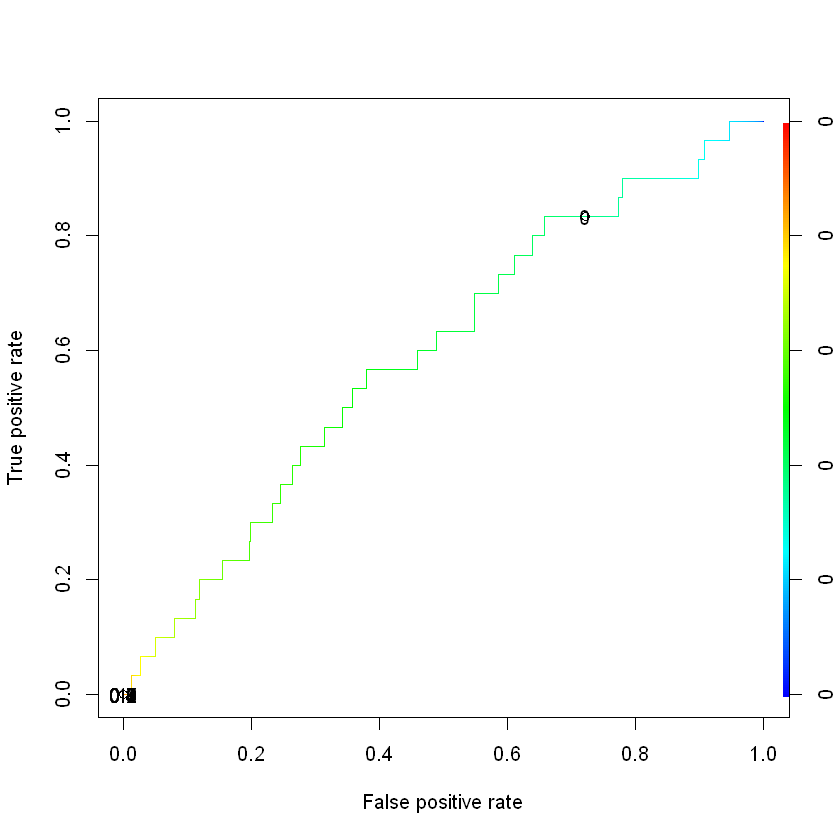

In [36]:
#ROC curves to help set threshold
ROCRpred = prediction(predictlm, liste2test$subscription_start)
ROCRperf = performance(ROCRpred, "tpr", "fpr")
plot(ROCRperf, colorize=TRUE, print.cutoffs.at=seq(0,1,0.1)) #seems to suggest a threshold between around .1

In [ ]:
##SOME OLD SCRIPTS BELOW / APPENDIX ## 

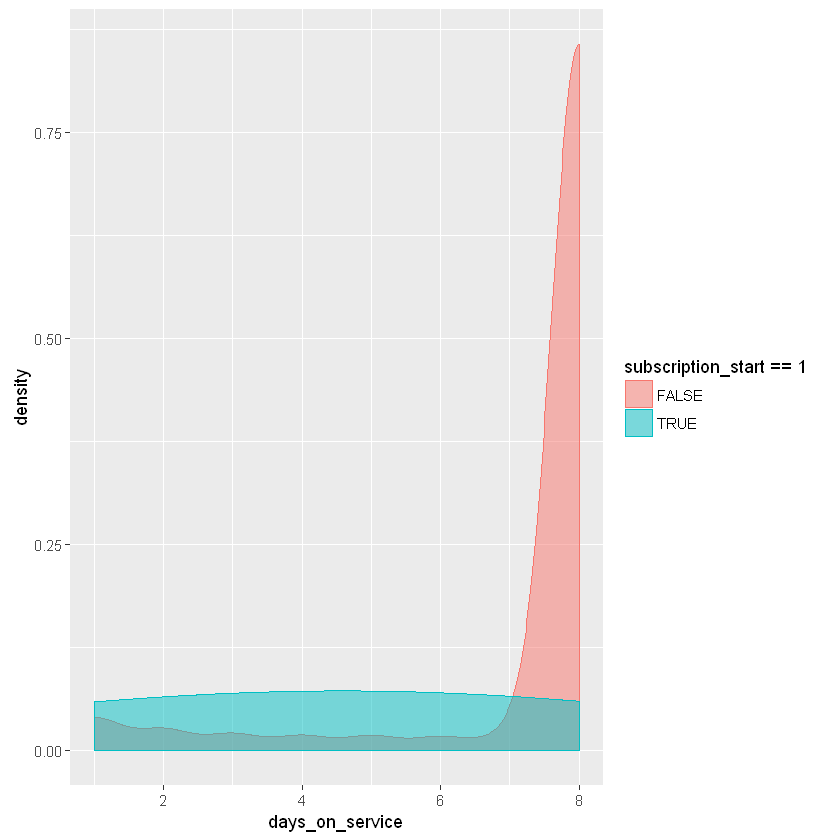

In [27]:
#plot distribution of days on service v3 to add a fill  
ggplot(LISTE, aes(x=days_on_service, fill = subscription_start == 1, colour = subscription_start == 1)) + 
geom_density(adjust = 5, alpha = 0.5)

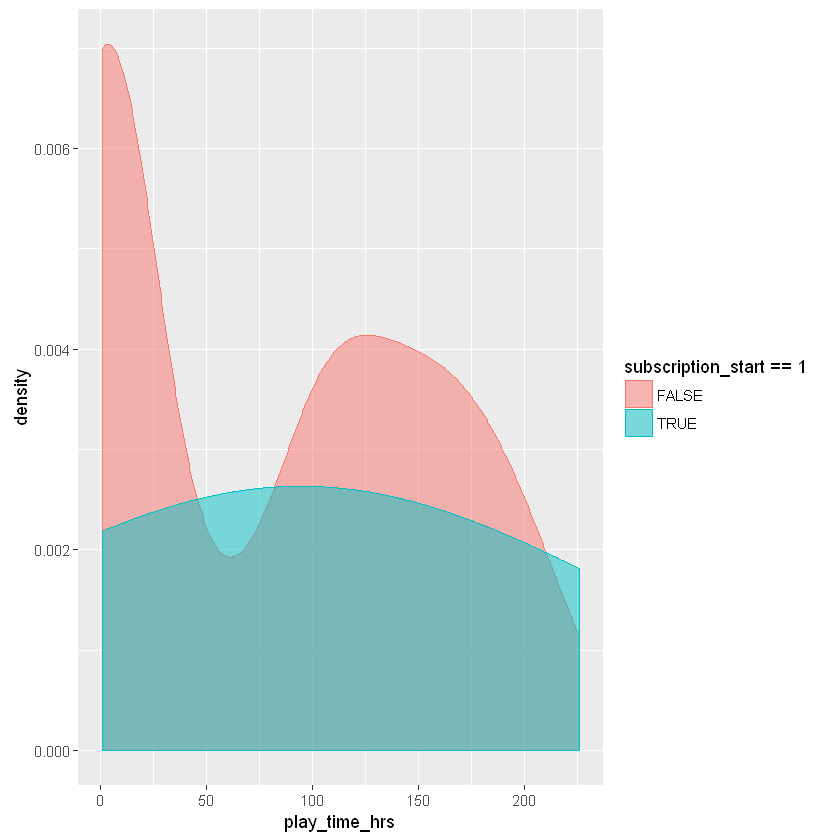

In [17]:
#plot distribution of play time  
ggplot(LISTE2, aes(x=play_time_hrs, fill = subscription_start == 1, colour = subscription_start == 1)) + 
geom_density(adjust = 5, alpha = 0.5)
#no clear cut off to suggest those that subscribe listen more hours than those who do not

#perhaps histogram is better for days on service and hours 


In [28]:
#run linear regression model on test data set and create table to see accuracy 
predictlm = predict(liste2R, newdata=liste2test)
table(liste2test$subscription_start, predictlm > 0.1)
table(liste2test$subscription_start, predictlm > 0.3)
table(liste2test$subscription_start, predictlm > 0.0005)
#what does the model say? Model says every listener is NOT changing and was right 497325/497355 times. It was wrong on the 30 that did change.


   
     FALSE
  0 497325
  1     30

   
     FALSE
  0 497325
  1     30

   
     FALSE
  0 497325
  1     30

In [33]:
#does pruning features help? 
liste2R2 <- lm(subscription_start ~ play_time_hrs + days_on_service + age + is_male_flag
               + null_zip_flag + smc_impressions, data = liste2train)
summary(liste2R2)
#how do I choose what to keep? 


Call:
lm(formula = subscription_start ~ play_time_hrs + days_on_service + 
    age + is_male_flag + null_zip_flag + smc_impressions, data = liste2train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.00034 -0.00010 -0.00005  0.00000  0.99984 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)      1.750e-04  1.411e-04   1.240   0.2150  
play_time_hrs   -1.042e-06  4.836e-07  -2.154   0.0313 *
days_on_service  2.114e-05  1.741e-05   1.214   0.2248  
age             -3.032e-07  2.307e-06  -0.131   0.8954  
is_male_flag     4.637e-05  6.313e-05   0.735   0.4626  
null_zip_flag   -1.895e-05  3.838e-04  -0.049   0.9606  
smc_impressions -2.191e-05  1.335e-05  -1.642   0.1006  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.007368 on 55254 degrees of freedom
Multiple R-squared:  0.000152,	Adjusted R-squared:  4.346e-05 
F-statistic:   1.4 on 6 and 55254 DF,  p-value: 0.2101


In [8]:
LISTE3 <- LISTE2 %>% select(play_time_hrs, days_on_service, age, is_male_flag, days_since_account_start, smc_impressions)
str(LISTE3)

'data.frame':	552616 obs. of  6 variables:
 $ play_time_hrs           : int  2 165 47 202 1 125 1 165 2 151 ...
 $ days_on_service         : int  3 5 4 6 1 2 1 7 2 7 ...
 $ age                     : int  35 45 34 48 37 42 40 30 45 63 ...
 $ is_male_flag            : int  0 1 0 0 1 1 0 1 0 0 ...
 $ days_since_account_start: int  3927 3924 3923 3922 3919 3897 3895 470 3848 3830 ...
 $ smc_impressions         : int  7 7 7 7 1 7 7 1 1 2 ...


In [13]:
#assume random cluster number... let's go with 7
k = 7
set.seed(7)
KMC = kmeans(LISTE3_scaled, centers = k, iter.max=1000)
str(KMC)

#look into TSNE (its in the notes from previous 1:1) 


List of 9
 $ cluster     : int [1:552616] 6 2 7 7 5 2 6 4 5 5 ...
 $ centers     : num [1:7, 1:6] -0.884 0.732 -0.486 0.189 0.486 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:7] "1" "2" "3" "4" ...
  .. ..$ : chr [1:6] "play_time_hrs" "days_on_service" "age" "is_male_flag" ...
 $ totss       : num 3315690
 $ withinss    : num [1:7] 180332 253522 235129 256296 248342 ...
 $ tot.withinss: num 1613764
 $ betweenss   : num 1701926
 $ size        : int [1:7] 80201 84858 60204 69742 71551 90972 95088
 $ iter        : int 6
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [15]:
KMC$centers[1:7]

[1] -0.8841528  0.7315392 -0.4858458  0.1885331  0.4860044 -0.8883783  0.7464414